# Exploring neighborhoods and venues in Atlanta

### Installing Folium - Python library for visualizing maps

In [250]:
!conda install -c conda-forge folium=0.5.0 --yes

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge


### Importing all the needed libraries

In [251]:
import pandas as pd
import folium
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import geopy
import requests

### Importing Atlanta neighborhood dataset

The Atlanta neighborhood dataset consists of 3 columns:
- **Neighborhood**: Lists all the neighborhoods in the city
- **Population**: Lists the population in each of the neighborhoods
- **NPU**: This is known as the *Neighborhood Planning Unit*. There are a total of 25 NPUs in Atlanta, similar to boroughs in the city of New York. Each NPU consists of several neighborhoods

In [252]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_dc8d30d252dd4735afdd8adc664a3b5f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='915bQVAdBZc2XWLfTX_TVMcR0Sa0hvh7wE46wf_8lidE',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_dc8d30d252dd4735afdd8adc664a3b5f.get_object(Bucket='ibmdatasciencecapstone-donotdelete-pr-piwzs0canialz0',Key='Atlanta_neighborhoods.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()



,Neighborhood,Population (2010),NPU
0,Adair Park,1331,V
1,Adams Park,1763,R
2,Adamsville,2403,H
3,Almond Park,1020,G
4,Ansley Park,2277,E


**Note: Some initial cleaning had to be done in Excel in order to remove non-ASCII characters which threw encoding errors while importing the CSV dataset. Thankfully, there were only 2 such instances.**

Now that we have our initial neighborhoods dataset, we can quickly look at a summary of the dataset and also make sure that we have all the neighborhoods

In [253]:
#Overview of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 3 columns):
Neighborhood         161 non-null object
Population (2010)    161 non-null int64
NPU                  161 non-null object
dtypes: int64(1), object(2)
memory usage: 3.9+ KB


We can see that the dataframe consists of 161 observations each representing a unique neighborhood of Atlanta. The number of columns is also specified (3). Also, the *info()* function reports that there are no *null* instances, which is good. 

In [254]:
#Data types of each variable
print (df.dtypes)

#Summary statistics for each numerical variable
df.describe(include="all")

Neighborhood         object
Population (2010)     int64
NPU                  object
dtype: object


,Neighborhood,Population (2010),NPU
count,161,161.000000,161
unique,161,NaN,25
top,Sylvan Hills,NaN,B
freq,1,NaN,15
mean,NaN,2381.844720,NaN
std,NaN,2287.806454,NaN
min,NaN,501.000000,NaN
25%,NaN,937.000000,NaN
50%,NaN,1738.000000,NaN
75%,NaN,2785.000000,NaN


Above, we first see that the *Population (2010)* parameter is the only numerical variable while the other two are of *object/string* type

Then we use the *describe()* function to print summary statistics for the numerical variable. From these stats, we can see that the mean population of a neighborhood is 2381.84472 and the maximum population in a neighborhood is 16569.

Another thing to take note of is that NPU *B* contains the most number of neighborhoods with a total of 15. We can also see that there are in fact 25 unique NPUs. 

Let's quickly change the name of the population column to something more simple

In [255]:
#Renaming the population column
df = df.rename(columns={"Population (2010)":"Population"})
df.head()

,Neighborhood,Population,NPU
0,Adair Park,1331,V
1,Adams Park,1763,R
2,Adamsville,2403,H
3,Almond Park,1020,G
4,Ansley Park,2277,E


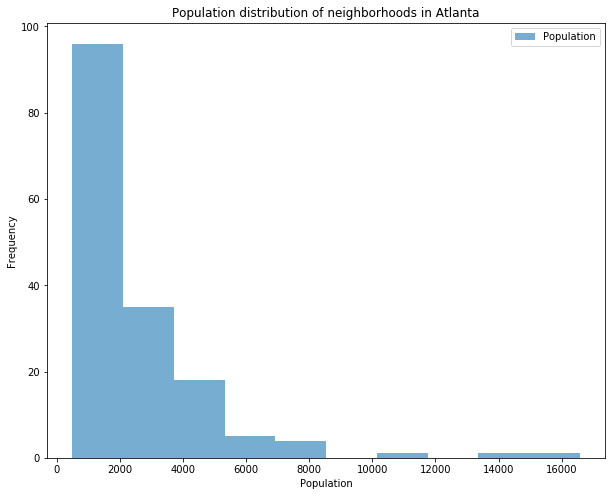

In [256]:
#Looking at the population distribution in each neighborhood
df.plot(kind='hist',alpha=0.6,figsize=(10,8))
plt.xlabel("Population")
plt.title("Population distribution of neighborhoods in Atlanta")
plt.show()

From the distribution above, it looks like most of the neighborhoods have a population of under 2000. In fact, the distribution is highly **right skewed**. From the summary stats table we saw earlier, the **upper quartile for population is 2785** which means that 75% of the neighborhoods have a population under 2785. This number falls on the extreme left of the histogram above which is one way to get a measure of the skewness. For a perfectly normal distribution, the median would lie somewhere around the center of the graph.

### Fetching latitude and longitude information for each neighborhood

Installing *geopy* library

In [257]:
#!conda install -c conda-forge geopy --yes

In [258]:
from geopy.geocoders import Nominatim

Let's try to fetch the coordinates for one of the neighborhoods - Adair Park

In [259]:
address = 'Whittier Mill Village Atlanta'

geolocator = Nominatim(user_agent="atl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of ',address,' are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  Whittier Mill Village Atlanta  are 36.164441, -95.955877.


The above coordinates match the coordinates shown on Google so we can potentially extract the coordinates in similar fashion for all of the neighborhoods. 

We can now loop through the neighborhoods and run the geolocator object to extract all the coordinates and include them in our dataframe. 

In [260]:
#Finding the coordinates for each neighborhood
lat = []
long = []

for i in df["Neighborhood"]:
    #location = geolocator.geocode(i.strip()+", GA",timeout=10)
    location = geolocator.geocode(i.strip()+" Atlanta",timeout=10)
    try:
        latitude = location.latitude
        longitude = location.longitude
        lat.append(latitude)
        long.append(longitude)
        print (i,latitude,longitude)
    except:
        latitude = 998
        longitude = 999
        lat.append(latitude)
        long.append(longitude)
        print (i,latitude,longitude)

Adair Park 33.7249743 -84.4114287
Adams Park 33.7120523 -84.4568734
Adamsville 33.7592737 -84.505209
Almond Park 998 999
Ansley Park 33.7945497 -84.3763154
Ardmore 33.8062822 -84.4000278
Argonne Forest 33.776905 -84.377668
Arlington Estates 998 999
Ashview Heights 33.7048298 -84.3785372
Atlanta University Center 33.7515434 -84.4135965377069
Atlantic Station 33.79078565 -84.4059253163346
Audubon Forest 33.7262187 -84.4704853
Baker Hills 998 999
Bankhead 33.7722351 -84.4288824
Beecher Hills 33.7231742 -84.4634111
Ben Hill 33.6906644 -84.5113194
Ben Hill Terrace 33.6906644 -84.5113194
Benteen Park 33.7151072 -84.3635367
Berkeley Park 33.9198247 -84.1704731
Betmar LaVilla 998 999
Bolton 33.8142719 -84.4532628
Boulevard Heights 33.6820526 -84.3810371
Brandon 33.816441 -84.415062
Brookhaven 33.8570926 -84.3464257850028
Brookwood 33.8026052 -84.3929827
Brookwood Hills 33.8078828 -84.3902048
Browns Mill Park 33.6859414 -84.3824261
Buckhead Forest 33.8398137 -84.3795589
Buckhead Village 33.8398

**Note: While fetching the coordinates using *geolocator.geocode()* the *timeout* value needed to be set to 10 to prevent a *Service timeout* error.**

Adding the latitudes and longitudes to the dataset

In [261]:
df["Latitude"] = lat
df["Longitude"] = long
df.head()

,Neighborhood,Population,NPU,Latitude,Longitude
0,Adair Park,1331,V,33.724974,-84.411429
1,Adams Park,1763,R,33.712052,-84.456873
2,Adamsville,2403,H,33.759274,-84.505209
3,Almond Park,1020,G,998.000000,999.000000
4,Ansley Park,2277,E,33.794550,-84.376315


You may have noticed that the *geolocator* was not able to fetch some of the coordinates. So we had a error catcher in the for loop which assigned a *(998,999)* coordinates to those. Let's see how many such instances exist in our dataset.

In [262]:
#Filtering the instances where the latitude and longitude are both 0
df_zero = df[(df["Latitude"]==998)&(df["Longitude"]==999)]
print ("Number of neighborhoods with missing coordinates: ",len(df_zero))
df_zero

Number of neighborhoods with missing coordinates:  38


,Neighborhood,Population,NPU,Latitude,Longitude
3,Almond Park,1020,G,998.0,999.0
7,Arlington Estates,776,P,998.0,999.0
12,Baker Hills,757,H,998.0,999.0
19,Betmar LaVilla,578,Y,998.0,999.0
32,Capitol Gateway,823,V,998.0,999.0
37,Carver Hills,681,G,998.0,999.0
38,Cascade Avenue/Road,2416,S,998.0,999.0
44,Chosewood Park,3790,Y,998.0,999.0
45,Custer/McDonough/Guice,1257,W,998.0,999.0
54,East Chastain Park,2065,B,998.0,999.0


Looks like we have 38 instances where the geolocator was not able to retrieve the exact coordinates. So to reduce time and effort, we can simply look up these 38 coordinates on Google and replace them in our dataset. It may be slightly painful to do it manually but this may eventually save us a lot of time. 

Before we do that, let's do an initial visualization of the coordinates using the *Folium* map vizualization library. 

In [263]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=4)

# add markers to map of Toronto neighborhoods
for lat, lng, npu, neighborhood in zip(df['Latitude'], df['Longitude'], df['NPU'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

On the map above, we can see that 5 coordinates have actually been misplaced as they seem to be far away from Atlanta or Georgia. For those points, we can manually look up the coordinates as well. These neighborhoods appear to be:

- Whittier Mill Village
- South Atlanta
- Piedmont Heights 
- Kings Forest
- Kingswood

Below we manually look up the coordinates on Google and store them in a data structure that is simple to work with. 

In [264]:
#Manual coordinates from Google
almond = (33.7815,-84.4671)
arlington = (33.6915,-84.5419)
baker = (33.7603,-84.5209)
betmar = (33.7068,-84.4009)
capitol = (33.7453,-84.3841)
carver_hills = (33.7993,-84.4606)
cascade_avenue = (33.749,-84.388)
chosewood = (33.7204,-84.3765)
custer = (33.7153,-84.3568)
chastain = (33.8682,-84.3844)
english = (33.7678,-84.4094)
fairburn = (33.5671,-84.581)
fairway = (33.6858,-84.5393)
glenrose = (33.675,-84.391)
harland = (33.7499,-84.4763)
chiles = (33.7447,-84.4212)
knight = (33.7794,-84.4199)
lindridge = (33.8155,-84.3568)
marietta_artery = (33.7723,-84.4022)
cascade = (33.7286,-84.5301)
monroe = (33.7954,-84.4882)
mount_paran = (33.8687,-84.4251)
ward = (33.7661,-84.3726)
alliance = (33.823,-84.3989)
heights_east = (33.8264,-84.3818)
heights_west = (33.8352,-84.3923)
penelope = (33.7517,-84.4527)
pamond = (998,999)
poncey = (33.7695,-84.3555)
south_river = (33.6625,-84.3595)
scotts = (33.8032,-84.4691)
tuxedo = (33.8461,-84.3871)
baywood = (33.6929,-84.3844)
carver = (33.7126,-84.3897)
castleberry = (33.7447,-84.4074)
east_lake = (33.7407,-84.313)
ferry = (33.8462,-84.4199)
meadows = (33.7519,-84.5209)

#Need to add the four remaining neighborhoods that were wrongly located
whittier = (33.8087,-84.4842)
south_atlanta = (33.7124,-84.3844)
piedmont = (33.8064,-84.3713)
kings = (36.097,-79.7386)
kingswood = (33.8556,-84.4133)


#Retrieving indexes of the missing neighborhoods
index = list(df_zero.index)

#combining all the missing coordinates tuples into a list for easier computation
missing_neighborhoods = [almond,arlington,baker,betmar,capitol,carver_hills,cascade_avenue,chosewood,custer,chastain,english,fairburn,fairway,glenrose,harland,
                        chiles,knight,lindridge,marietta_artery,cascade,monroe,mount_paran,ward,alliance,heights_east,heights_west,
                         penelope,pamond,poncey,south_river,scotts,tuxedo,baywood,carver,castleberry,east_lake,ferry,meadows,
                        whittier,south_atlanta,piedmont,kings,kingswood]
#Unzipping the list of tuples to separate the latitudes and longitudes into separate lists/tuples
missing_neighborhoods = list(zip(*missing_neighborhoods))
missing_neighborhoods

[(33.7815,
  33.6915,
  33.7603,
  33.7068,
  33.7453,
  33.7993,
  33.749,
  33.7204,
  33.7153,
  33.8682,
  33.7678,
  33.5671,
  33.6858,
  33.675,
  33.7499,
  33.7447,
  33.7794,
  33.8155,
  33.7723,
  33.7286,
  33.7954,
  33.8687,
  33.7661,
  33.823,
  33.8264,
  33.8352,
  33.7517,
  998,
  33.7695,
  33.6625,
  33.8032,
  33.8461,
  33.6929,
  33.7126,
  33.7447,
  33.7407,
  33.8462,
  33.7519,
  33.8087,
  33.7124,
  33.8064,
  36.097,
  33.8556),
 (-84.4671,
  -84.5419,
  -84.5209,
  -84.4009,
  -84.3841,
  -84.4606,
  -84.388,
  -84.3765,
  -84.3568,
  -84.3844,
  -84.4094,
  -84.581,
  -84.5393,
  -84.391,
  -84.4763,
  -84.4212,
  -84.4199,
  -84.3568,
  -84.4022,
  -84.5301,
  -84.4882,
  -84.4251,
  -84.3726,
  -84.3989,
  -84.3818,
  -84.3923,
  -84.4527,
  999,
  -84.3555,
  -84.3595,
  -84.4691,
  -84.3871,
  -84.3844,
  -84.3897,
  -84.4074,
  -84.313,
  -84.4199,
  -84.5209,
  -84.4842,
  -84.3844,
  -84.3713,
  -79.7386,
  -84.4133)]

That took a bit of an effort but we finally have the missing coordinates into a structure that we can manipulate and get the data we want out of. With some manual work, the latitudes and longitudes are now split into separate tuples which are contained in a single list. This kind of structure will allow us to easily loop through it and extract the information that we need. 

Next we need to find the indices of the 5 outlying neighborhoods and add them to the *index* variable

In [265]:
for i in range(len(index)):
    print (i)
    print (missing_neighborhoods[0][i])
    df.iloc[index[i],:] = df.iloc[index[i],:].replace(998,missing_neighborhoods[0][i])
    df.iloc[index[i],:] = df.iloc[index[i],:].replace(999,missing_neighborhoods[1][i])
    
df.iloc[19,:]

0
33.7815
1
33.6915
2
33.7603
3
33.7068
4
33.7453
5
33.7993
6
33.749
7
33.7204
8
33.7153
9
33.8682
10
33.7678
11
33.5671
12
33.6858
13
33.675
14
33.7499
15
33.7447
16
33.7794
17
33.8155
18
33.7723
19
33.7286
20
33.7954
21
33.8687
22
33.7661
23
33.823
24
33.8264
25
33.8352
26
33.7517
27
998
28
33.7695
29
33.6625
30
33.8032
31
33.8461
32
33.6929
33
33.7126
34
33.7447
35
33.7407
36
33.8462
37
33.7519


Neighborhood    Betmar LaVilla
Population                 578
NPU                          Y
Latitude               33.7068
Longitude             -84.4009
Name: 19, dtype: object

In the above cell, we have looped through the indices containing the missing coordinates and replaced the *998* and *999* dummy values with the actual coordinates contained in the *missing_neighborhood* variable. 

Let's check to confirm that the substitions were effective

In [266]:
#Looping through the 25 instances in question to check if the coordinates replacement took effect
for i in range(len(index)):
    print (df.iloc[index[i],:])
    print ("")

Neighborhood    Almond Park
Population             1020
NPU                       G
Latitude            33.7815
Longitude          -84.4671
Name: 3, dtype: object

Neighborhood    Arlington Estates
Population                    776
NPU                             P
Latitude                  33.6915
Longitude                -84.5419
Name: 7, dtype: object

Neighborhood    Baker Hills
Population              757
NPU                       H
Latitude            33.7603
Longitude          -84.5209
Name: 12, dtype: object

Neighborhood    Betmar LaVilla
Population                 578
NPU                          Y
Latitude               33.7068
Longitude             -84.4009
Name: 19, dtype: object

Neighborhood    Capitol Gateway
Population                  823
NPU                           V
Latitude                33.7453
Longitude              -84.3841
Name: 32, dtype: object

Neighborhood    Carver Hills
Population               681
NPU                        G
Latitude             33.7

In [267]:
#temp = df

In [268]:
#df=temp

Looks like the coordinates substitutions worked. Next, let's add in those four outlying coordinates we saw on the map

In [269]:
#Finding the indices of the 4 outlying coordinates from the earlier map
whittier_index = df[df["Neighborhood"]=="Whittier Mill Village"].index[0]
south_atlanta_index = df[df["Neighborhood"]=="South Atlanta"].index[0]
piedmont_index = df[df["Neighborhood"]=="Piedmont Heights"].index[0]
kings_index = df[df["Neighborhood"]=="Kings Forest"].index[0]
kingswood_index = df[df["Neighborhood"]=="Kingswood"].index[0]

#Checking the data for the 4 outlying locations
print (df.iloc[whittier_index,:])
print (df.iloc[south_atlanta_index,:])
print (df.iloc[piedmont_index,:])
print (df.iloc[kings_index,:])
print (df.iloc[kingswood_index,:])

Neighborhood    Whittier Mill Village
Population                        617
NPU                                 D
Latitude                      36.1644
Longitude                    -95.9559
Name: 157, dtype: object
Neighborhood    South Atlanta
Population               1738
NPU                         Y
Latitude              33.1162
Longitude            -94.1663
Name: 132, dtype: object
Neighborhood    Piedmont Heights
Population                  2323
NPU                            F
Latitude                 36.0412
Longitude               -79.8072
Name: 118, dtype: object
Neighborhood    Kings Forest
Population              1674
NPU                        P
Latitude             45.1514
Longitude           -64.5041
Name: 78, dtype: object
Neighborhood    Kingswood
Population            660
NPU                     A
Latitude          33.1137
Longitude        -94.1644
Name: 79, dtype: object


In [270]:
#First dropping the outliers from the original dataset and then appending the right ones at the end of the dataset
df = df.drop([whittier_index,south_atlanta_index,piedmont_index,kings_index,kingswood_index])
df = df.append(pd.DataFrame([["Whittier Mill Village",617,'D',whittier[0],whittier[1]]],columns=df.columns))
df = df.append(pd.DataFrame([["South Atlanta",1738,'Y',south_atlanta[0],south_atlanta[1]]],columns=df.columns))
df = df.append(pd.DataFrame([["Piedmont Heights",2323,'F',piedmont[0],piedmont[1]]],columns=df.columns))
df = df.append(pd.DataFrame([["Kings Forest",1674,'P',kings[0],kings[1]]],columns=df.columns))
df = df.append(pd.DataFrame([["Kingswood",660,'A',kingswood[0],kingswood[1]]],columns=df.columns))
df

,Neighborhood,Population,NPU,Latitude,Longitude
0,Adair Park,1331,V,33.724974,-84.411429
1,Adams Park,1763,R,33.712052,-84.456873
2,Adamsville,2403,H,33.759274,-84.505209
3,Almond Park,1020,G,33.781500,-84.467100
4,Ansley Park,2277,E,33.794550,-84.376315
5,Ardmore,756,E,33.806282,-84.400028
6,Argonne Forest,590,C,33.776905,-84.377668
7,Arlington Estates,776,P,33.691500,-84.541900
8,Ashview Heights,1292,T,33.704830,-84.378537
9,Atlanta University Center,5703,T,33.751543,-84.413597


In [271]:
#Re-indexing
df.index = range(df.shape[0])
df

,Neighborhood,Population,NPU,Latitude,Longitude
0,Adair Park,1331,V,33.724974,-84.411429
1,Adams Park,1763,R,33.712052,-84.456873
2,Adamsville,2403,H,33.759274,-84.505209
3,Almond Park,1020,G,33.781500,-84.467100
4,Ansley Park,2277,E,33.794550,-84.376315
5,Ardmore,756,E,33.806282,-84.400028
6,Argonne Forest,590,C,33.776905,-84.377668
7,Arlington Estates,776,P,33.691500,-84.541900
8,Ashview Heights,1292,T,33.704830,-84.378537
9,Atlanta University Center,5703,T,33.751543,-84.413597


However there is one last thing to rectify, the *Pamond Park* coordinates. Recall that we had once again placed dummy variables *998* and *999* for this neighborhood since the actual coordinates were not found on Google. For simplicity we are going to get rid of this neighborhood instance all together, which should leave us with a total of 160 neighborhoods which actually works as a more user-friendly number. 

In [272]:
#Checking to see where in the dataframe Pamond Park is
pamond_park_index = df[df["Neighborhood"]=="Pamond Park"].index[0]
print ("The Pamond Park neighborhood instance is at index",pamond_park_index)

The Pamond Park neighborhood instance is at index 119


In [273]:
#Dropping the Pamond Park index from the dataset using its index
df = df.drop(pamond_park_index)

In [274]:
#Confirming the shape of the new dataframe
df.shape

(160, 5)

In [275]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 160
Data columns (total 5 columns):
Neighborhood    160 non-null object
Population      160 non-null int64
NPU             160 non-null object
Latitude        160 non-null float64
Longitude       160 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 7.5+ KB


,Neighborhood,Population,NPU,Latitude,Longitude
0,Adair Park,1331,V,33.724974,-84.411429
1,Adams Park,1763,R,33.712052,-84.456873
2,Adamsville,2403,H,33.759274,-84.505209
3,Almond Park,1020,G,33.781500,-84.467100
4,Ansley Park,2277,E,33.794550,-84.376315


We now have all the data formatted and cleaned in our dataset. There was also a fair bit of manual and automated data collection involved. 

The dataset now consists of 160 neighborhoods and all their coordinates. The neighborhoods can be visualized again to see if our data cleaning worked.

### Visualizing neighborhoods across Atlanta

In [276]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=4)

# add markers to map of Toronto neighborhoods
for lat, lng, npu, neighborhood in zip(df['Latitude'], df['Longitude'], df['NPU'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

There seems to be only one place that remains misplaced - Kings Forest. As the actual coordinates were not found despite doing a manual Google search, we can exclude this point from our dataset. Considering we have 159 other instances, this should not be a problem. 

In [277]:
kings_index = df[df["Neighborhood"]=="Kings Forest"].index[0]
print ("The index of Kings Forest is",kingswood_index)

The index of Kings Forest is 79


In [278]:
#Dropping the Kingswood instance
df = df.drop(kings_index)

In [279]:
df.shape

(159, 5)

Now that we have confirmed that the shape is as expected let's plot the neighborhoods again with the United States perspective. 

In [280]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=4)

# add markers to map of Toronto neighborhoods
for lat, lng, npu, neighborhood in zip(df['Latitude'], df['Longitude'], df['NPU'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

From the map above, we can see that all the points are now concentrated within the Atlanta area. So now, the same points can be visualized again but from just the Atlanta perspective with a greater zoom. 

In [281]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=10)

# add markers to map of Toronto neighborhoods
for lat, lng, npu, neighborhood in zip(df['Latitude'], df['Longitude'], df['NPU'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

The map shows all 159 neighborhoods scattered densely across Atlanta. For our purposes, we can further narrow this dataset down by filtering out neighborhoods that are outside the I-285 circle. Since our aim is to find areas of maximum traffic, it is more likely that we would find our desirable location within the circle which is more densely populated as can be seen from the map above. 

In order to visualize the density of the various neighborhoods, we can split the dataset into high population count neighborhoods and low ones. 

In [282]:
#Sorting the dataset based on population
df_pop = df.sort_values(by="Population",ascending=False)
df_pop.head()

#Splitting the dataset into the top 130 and bottom 29 based on population
df_pop_high = df_pop.iloc[:79,:]
df_pop_low = df_pop.iloc[79:,:]

print (df_pop_high.head())
print ("")
print (df_pop_low)

        Neighborhood  Population NPU   Latitude  Longitude
93           Midtown       16569   E  33.781646 -84.386379
51          Downtown       13411   M  33.748309 -84.392118
102  Old Fourth Ward       10505   M  33.766100 -84.372600
99    North Buckhead        8270   B  33.839814 -84.379559
116       Pine Hills        8033   B  33.919825 -84.170473

                   Neighborhood  Population NPU   Latitude  Longitude
35                   Carey Park        1739   G  33.783717 -84.471874
157               South Atlanta        1738   Y  33.712400 -84.384400
15                     Ben Hill        1725   P  33.690664 -84.511319
97                  Mozley Park        1714   K  33.753440 -84.438262
123              Ridgedale Park        1685   B  33.753365 -84.321750
84                        Lenox        1663   B  33.845393 -84.358129
98          Mt. Paran/Northside        1568   A  33.868700 -84.425100
107   Peachtree Battle Alliance        1540   C  33.823000 -84.398900
143   The Villa

Next we can visualize both the high population dataset and the low population one on the same Atlanta map to see the spread of the neighborhoods based on population density. 

In [283]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=10)

# add markers to map of Atlanta neighborhoods for the highest populated neighborhoods
for lat, lng, npu, neighborhood in zip(df_pop_high['Latitude'], df_pop_high['Longitude'], df_pop_high['NPU'], df_pop_high['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  

#Lowest populated neighborhoods
for lat, lng, npu, neighborhood in zip(df_pop_low['Latitude'], df_pop_low['Longitude'], df_pop_low['NPU'], df_pop_low['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

We can see from the map that there is no clear distinction between the densely populated areas and the lower ones. Although, we could still narrow the dataset down to include points inside the I-285 circle. 

For this we can simply find the distance from the center of Atlanta (33.7490, -84.388) to one of the coordinates on the circumference of the I-285 cirelce (33.793697, -84.4878). Then we can filter out points that lie outside of this radius.

The first step would be to determine the distance between the center of Atlanta to each of the neighborhoods.

#### Function to calculate the Euclidian distance

In [284]:
def dist(x1,x2):
    distance = []
    coord = zip(x1,x2)
    for i in coord:
        distance.append(np.sqrt(np.square((i[0]-33.749))+np.square((i[1]-(-84.388)))))
    return distance

In [285]:
#Distance between Atlanta and I-285 circumference
i285 = dist((33.7490,33.793697),(-84.388,-84.4878))[1]
print ("Distance from Atlanta to I-285 circle",i285)

Distance from Atlanta to I-285 circle 0.10935200871


The first output above is the distance from Atlanta to Atlanta so a 0 makes sense. The distance between the I-285 and Atlanta is 0.10935

#### Determining the distance from each neighborhood to the Atlanta coordinates

In [286]:
neighborhood_dist = dist(df["Latitude"],df["Longitude"])
df["Distance"] = neighborhood_dist
df.head()

,Neighborhood,Population,NPU,Latitude,Longitude,Distance
0,Adair Park,1331,V,33.724974,-84.411429,0.033558
1,Adams Park,1763,R,33.712052,-84.456873,0.078158
2,Adamsville,2403,H,33.759274,-84.505209,0.117658
3,Almond Park,1020,G,33.781500,-84.467100,0.085516
4,Ansley Park,2277,E,33.794550,-84.376315,0.047025


Next we determine which neighborhoods are outside the I-285

In [287]:
#Filtering out neighborhoods outside the circle
df_inside = df[df["Distance"]<i285]
df_inside

,Neighborhood,Population,NPU,Latitude,Longitude,Distance
0,Adair Park,1331,V,33.724974,-84.411429,0.033558
1,Adams Park,1763,R,33.712052,-84.456873,0.078158
3,Almond Park,1020,G,33.781500,-84.467100,0.085516
4,Ansley Park,2277,E,33.794550,-84.376315,0.047025
5,Ardmore,756,E,33.806282,-84.400028,0.058531
6,Argonne Forest,590,C,33.776905,-84.377668,0.029756
8,Ashview Heights,1292,T,33.704830,-84.378537,0.045172
9,Atlanta University Center,5703,T,33.751543,-84.413597,0.025723
10,Atlantic Station,1888,E,33.790786,-84.405925,0.045468
11,Audubon Forest,813,I,33.726219,-84.470485,0.085573


In [288]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=11)

# add markers to map of Atlanta neighborhoods for the highest populated neighborhoods
for lat, lng, npu, neighborhood in zip(df_inside['Latitude'], df_inside['Longitude'], df_inside['NPU'], df_inside['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

The above map has all the neighborhoods inside the I-285 circle and is the final set of points we will use for further analysis. Note that they are all in fact inside the circle.

The next step is to explore the venues in each of these neighborhoods and find out what kind of establishments are nearby and what attributes for each of these locations we could use to come up with a suitable location for the retail store. 

To explore the venues, the *Foursquare* API will be used. First, the credentials need to be set in order to initialize the API.

### Defining Foursquare credentials

In [289]:
CLIENT_ID = 'XGFKFRJ4JHHTPCO3QGCBD3PJFRFBNFH4YGZBAGZSGQQDH1I3' # your Foursquare ID
CLIENT_SECRET = 'J3KQGEDWB1MJ4MFF3Y5SHZ3SVA5VPMKFYS2XRZV4HVTB35AP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XGFKFRJ4JHHTPCO3QGCBD3PJFRFBNFH4YGZBAGZSGQQDH1I3
CLIENT_SECRET:J3KQGEDWB1MJ4MFF3Y5SHZ3SVA5VPMKFYS2XRZV4HVTB35AP


To discover venues around a certain coordinate, the Foursquare API contains the *explore* endpoint that allows us retrieve venues by supplying the credentials as well as the coordinates, radius (around the coordinate) and limit (number of results to retrieve). 

Below we can explore venues around a given coordinate and see what it contains.

In [290]:
print (df_inside.iloc[0])

Neighborhood    Adair Park
Population            1331
NPU                      V
Latitude            33.725
Longitude         -84.4114
Distance          0.033558
Name: 0, dtype: object


In [291]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            df_inside.iloc[0,3], 
            df_inside.iloc[0,4], 
            500, 
            10)

results = requests.get(url).json()["response"]['groups'][0]['items']
results

[{'reasons': {'count': 0,
   'items': [{'reasonName': 'globalInteractionReason',
     'summary': 'This spot is popular',
     'type': 'general'}]},
  'referralId': 'e-0-4d87b69c033fcbfffc0d522c-0',
  'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_',
      'suffix': '.png'},
     'id': '4bf58dd8d48988d1c5941735',
     'name': 'Sandwich Place',
     'pluralName': 'Sandwich Places',
     'primary': True,
     'shortName': 'Sandwiches'}],
   'id': '4d87b69c033fcbfffc0d522c',
   'location': {'address': '1217 Metropolitan Pkwy SW',
    'cc': 'US',
    'city': 'Atlanta',
    'country': 'United States',
    'distance': 448,
    'formattedAddress': ['1217 Metropolitan Pkwy SW',
     'Atlanta, GA 30310',
     'United States'],
    'labeledLatLngs': [{'label': 'display',
      'lat': 33.721898397100226,
      'lng': -84.40830276519158}],
    'lat': 33.721898397100226,
    'lng': -84.40830276519158,
    'postalCode': '30310',
    'state': 'GA'},
   '

From the above API request, we can see the contents of the response. From the results, we can extract attributes such as *Name*, *Category* and *Distance*

Below define a function that retrieves all of this information for all the neighborhoods in our dataset by making a call to the API and finally storing it in a dataset

In [292]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT = 100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            df_inside[df_inside["Neighborhood"]==name]["Population"].iloc[0],
            df_inside[df_inside["Neighborhood"]==name]["NPU"].iloc[0],
            v['venue']['location']['distance'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Neighborhood Pop',
                  'NPU',
                  'Venue Distance',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can make a call to the above function by passing in as arguements the neighborhoods and their coordinates. 

In [293]:
atlanta_venues = getNearbyVenues(names=df_inside['Neighborhood'],
                                   latitudes=df_inside['Latitude'],
                                   longitudes=df_inside['Longitude']
                                   )

Adair Park
Adams Park
Almond Park
Ansley Park
Ardmore
Argonne Forest
Ashview Heights
Atlanta University Center
Atlantic Station
Audubon Forest
Bankhead
Beecher Hills
Benteen Park
Betmar LaVilla
Bolton
Boulevard Heights
Brandon
Brookwood
Brookwood Hills
Browns Mill Park
Buckhead Forest
Buckhead Village
Cabbagetown
Candler Park
Capitol Gateway
Capitol View
Capitol View Manor
Carey Park
Carver Hills
Cascade Avenue/Road
Cascade Heights
Castleberry Hill
Castlewood
Center Hill
Chosewood Park
Custer/McDonough/Guice
Collier Hills
Cross Creek
Dixie Hills
Downtown
Druid Hills
East Atlanta
East Lake
Edgewood
English Avenue
Florida Heights
Fort McPherson
Georgia Tech
Glenrose Heights
Grant Park
Grove Park
Hammond Park
Harland Terrace
Harris Chiles
Hills Park
Hunter Hills
Inman Park
Joyland
Kirkwood
Knight Park/Howell Station
Lake Claire
Lakewood
Lakewood Heights
Leila Valley
Lenox
Lincoln Homes
Lindbergh
Lindridge/Martin Manor
Loring Heights
Margaret Mitchell
Marietta Street Artery
Mays
Mechanicsv

Let's take a look at the resulting dataframe containing the venue information for each neighborhood. We have the *venue name*, the *distance* from the neighborhood coordinates, the *category* of the venue and the *coordinates* of the venue. 

In [294]:
atlanta_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Pop,NPU,Venue Distance,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adair Park,33.724974,-84.411429,1331,V,448,Subway,33.721898,-84.408303,Sandwich Place
1,Adair Park,33.724974,-84.411429,1331,V,454,Chevron,33.721888,-84.408213,Gas Station
2,Adair Park,33.724974,-84.411429,1331,V,468,Atlanta Food Mart,33.722240,-84.407578,Convenience Store
3,Adair Park,33.724974,-84.411429,1331,V,248,Atlanta Beltline Westside Trail,33.726212,-84.413658,Trail
4,Adair Park,33.724974,-84.411429,1331,V,274,The Bakery,33.724926,-84.414390,Art Gallery
5,Adair Park,33.724974,-84.411429,1331,V,431,McNealy and Associates,33.722022,-84.414447,Print Shop
6,Adair Park,33.724974,-84.411429,1331,V,475,Urban Vines Wine Company,33.729072,-84.412881,Wine Bar
7,Adair Park,33.724974,-84.411429,1331,V,483,Wings And Seafood,33.721634,-84.408092,Wings Joint
8,Adair Park,33.724974,-84.411429,1331,V,485,Metro Package Store,33.721622,-84.408081,Liquor Store
9,Adams Park,33.712052,-84.456873,1763,R,421,Abdullah The Butcher,33.710668,-84.461110,BBQ Joint


Let's see how many unique categories there are 

In [295]:
#Number of unique venue categories
print ("Number of unique categories across all neighborhoods",len(set(atlanta_venues["Venue Category"])))

#Total number of venues
print ("Total number of venues",df.shape[0])

Number of unique categories across all neighborhoods 259
Total number of venues 159


The categories can be grouped together to find out which are the most common categories across Atlanta and their frequencies. 

In [296]:
#Looking at the distribution of categories
categories = pd.DataFrame()
categories["Frequency"] = atlanta_venues.groupby("Venue Category").apply(len)
categories["Categories"] = list(atlanta_venues.groupby("Venue Category").apply(len).index)
categories.index = range(categories.shape[0])

#Sorting the categories from descending order
categories = categories.sort_values(by="Frequency",ascending=False)

#The top 20 categories
cat_top = categories.head(20)
print (cat_top)
print ("")

#The bottom 20 categories
cat_bottom = categories.tail(20)
print (cat_bottom)

     Frequency                       Categories
182         61                             Park
3           52              American Restaurant
114         46                              Gym
206         43                   Sandwich Place
15          43                              Bar
189         42                      Pizza Place
50          41                      Coffee Shop
48          34                   Clothing Store
87          33             Fast Food Restaurant
222         32  Southern / Soul Food Restaurant
30          29                   Breakfast Spot
157         28               Mexican Restaurant
126         28                            Hotel
6           26                      Art Gallery
115         25             Gym / Fitness Center
201         25                       Restaurant
104         23                      Gas Station
40          22                             Café
208         22               Seafood Restaurant
112         22                    Grocer

Above we can see the top 20 categories and the bottom 20 categories for venues in Atlanta. This is good information to have as it tells us which categories to look for and which cetegories to potentially avoid when looking for a location to maximize traffic. 

For example, if we look at the most visited venues, *parks* are number one with a frequency of 64 followed by *American restaurant*, *Bar*, *Sandwich place* and *Coffee shop*. These are in fact some of the most popular and regular destinations for people in a city. Some of the other high volume venues that make the list are *Breakfast spot*, *Hotel*, *Gas station* and even *Clothing stores*. It is a trend among businesses to situate their stores close to competitors simply to attract crowds with similar needs. Therefore, you will often see multiple fastfood restaurants close to one another and several gas stations in close proximity to each other. 

To represent the above data better, we can display it using bar charts. 

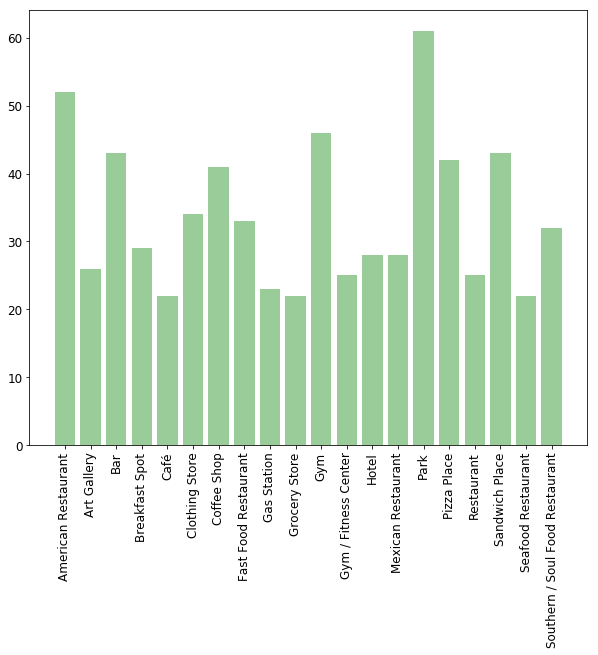

In [297]:
#Visualizing the top 20 categories
plt.figure(figsize=(10,8))
plt.bar(cat_top["Categories"],cat_top["Frequency"],alpha=0.4,color="green")
plt.xticks(rotation=90,size=12)
plt.yticks(size=12)
plt.show()


Next we can group the data by neighborhoods to see which ones consist of the highest number of venues, this would provide a good indication as to which neighborhoods might experience more traffic. 

### Group dataset by neighborhoods to see which neighborhoods have the highest density of venues

In [298]:
#Group by neighborhood
neighborhood_group = atlanta_venues.groupby("Neighborhood").apply(len)
neighborhood_group = neighborhood_group.sort_values(ascending=False)
neighborhood_group.head(30)

Neighborhood
Margaret Mitchell         100
Midtown                   100
Peachtree Park            100
Lenox                      80
Paces                      69
Inman Park                 62
Buckhead Forest            61
North Buckhead             61
Buckhead Village           61
Wisteria Gardens           61
Underwood Hills            47
Poncey-Highland            44
East Atlanta               43
Sweet Auburn               41
Druid Hills                40
Castleberry Hill           35
Virginia-Highland          35
Collier Hills              32
Lindridge/Martin Manor     31
Atlantic Station           29
Grant Park                 27
Brookwood                  26
Cabbagetown                25
Springlake                 25
Marietta Street Artery     24
Brookwood Hills            23
Lindbergh                  22
Ridgedale Park             21
Hills Park                 20
Cascade Avenue/Road        20
dtype: int64

In [299]:
#neighborhood_group.shape

The top 30 neighborhoods based on the number of venues has at least 20 venues in it's vicinity. Therefore, we can eliminate the rest of the neighborhoods from consideration as our goal is to look for areas of high traffic. 

In [300]:
#Retrieving the 83 neighborhoods with the lowest number of venues
bottom = list(neighborhood_group.tail(83).index)
len(bottom)

83

First, the *Neighborhood* column is set as the index which allows us to remove instances in the dataset that contain any of the *bottom 83* neighborhoods. 

In [301]:
#Dropping the bottom 83 neighborhoods
atlanta_venues_30 = atlanta_venues.set_index("Neighborhood")
atlanta_venues_30 = atlanta_venues_30.drop(bottom)
atlanta_venues_30 = atlanta_venues_30.reset_index()
print (atlanta_venues_30.head())

       Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Atlantic Station              33.790786              -84.405925   
1  Atlantic Station              33.790786              -84.405925   
2  Atlantic Station              33.790786              -84.405925   
3  Atlantic Station              33.790786              -84.405925   
4  Atlantic Station              33.790786              -84.405925   

   Neighborhood Pop NPU  Venue Distance                      Venue  \
0              1888   E             224                       HEAT   
1              1888   E             265                       IKEA   
2              1888   E             314  Stoddard's Range and Guns   
3              1888   E              59           McAlister’s Deli   
4              1888   E             315          Swinging Richards   

   Venue Latitude  Venue Longitude          Venue Category  
0       33.792257       -84.404261                     Gym  
1       33.788612       -84.404752  

The number of unique neighborhoods is printed to confirm that there are in fact 30 of them remaining. 

In [302]:
#Print the unique neighborhoods in the dataset
print ("Number of unique neighborhoods",len(atlanta_venues_30["Neighborhood"].unique()))

Number of unique neighborhoods 30


Before proceeding further, let's take another look at the neighborhoods using the *Folium* mapping library

In [303]:
# create map of Toronto using latitude and longitude values
map_atlanta = folium.Map(location=[33.7490, -84.388], zoom_start=11)

# add markers to map of Atlanta neighborhoods for the highest populated neighborhoods
for lat, lng, neighborhood in zip(atlanta_venues_30['Neighborhood Latitude'], atlanta_venues_30['Neighborhood Longitude'],atlanta_venues_30['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

After the previous round of filtering, we are now left with 30 neighborhoods which appear to be centrally located on the Atlanta map. Since these neighborhoods consist of the largest number of venues, this makes sense.

Let's take a look at the resulting dataframe. 

In [304]:
atlanta_venues_30.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Pop,NPU,Venue Distance,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Atlantic Station,33.790786,-84.405925,1888,E,224,HEAT,33.792257,-84.404261,Gym
1,Atlantic Station,33.790786,-84.405925,1888,E,265,IKEA,33.788612,-84.404752,Furniture / Home Store
2,Atlantic Station,33.790786,-84.405925,1888,E,314,Stoddard's Range and Guns,33.792995,-84.403804,Gun Shop
3,Atlantic Station,33.790786,-84.405925,1888,E,59,McAlister’s Deli,33.791072,-84.406468,Deli / Bodega
4,Atlantic Station,33.790786,-84.405925,1888,E,315,Swinging Richards,33.792949,-84.408137,Strip Club


In [305]:
atlanta_venues_30.shape

(1365, 10)

We are left with 159 venues in total spanning 30 neighborhoods. Let's check how many unique categories exist across the neighborhoods. 

In [306]:
#Unique venue categories
print ("There are",len(atlanta_venues_30["Venue Category"].unique()),"unique venue categories")

There are 216 unique venue categories


That's a lot of categories but we need to cluster the neighborhoods by preferably distinguishing between the high traffic and low traffic venues. 

Some of the high traffic venues that we are interested in are: 

- Restaurants
- Coffee shops
- Bars
- Parks
- Malls 
- Hotels

Secondly we also want to distinguish areas with venues that complement retail stores such as:

- Gas stations
- Parking lots
- Other clothing stores

First, we analyze the different venue categories by transforming the venues into a *sparse matrix* format. A **sparse matrix** is a matrix where each unique category (in this case) is set as a separate feature. If the category exists for that instance (neighborhood) in the dataframe, the entry is a *1* otherwise it's a *0*. 

So for example, if there are 8 unique categories, the sparse matrix would contain 8 columns (for each category) and rows equal to the number of observations (neighborhoods) in the original dataset. 

In [307]:
# one hot encoding
atlanta_onehot = pd.get_dummies(atlanta_venues_30[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
atlanta_onehot['Neighborhood'] = atlanta_venues_30['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [atlanta_onehot.columns[-1]] + list(atlanta_onehot.columns[:-1])
atlanta_onehot = atlanta_onehot[fixed_columns]

atlanta_onehot.head()

,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we can see above, the sparse matrix mostly consists of 0 values. There are 255 columns which is the same as the number of unique categories as we discovered earlier. 

The next step would be find the highest occurring venues for each neighborhood. 

In [308]:
atlanta_onehot.shape

(1365, 216)

The sparse matrix consists of 1866 rows which equals the number of observations in our dataset. 

In [309]:
atlanta_grouped = atlanta_onehot.groupby('Neighborhood').mean().reset_index()
atlanta_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Atlantic Station,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,Brookwood,0.000000,0.000000,0.000000,0.00000,0.038462,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
2,Brookwood Hills,0.000000,0.000000,0.000000,0.00000,0.043478,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
3,Buckhead Forest,0.000000,0.000000,0.000000,0.00000,0.016393,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.016393,0.000000
4,Buckhead Village,0.000000,0.000000,0.000000,0.00000,0.016393,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.016393,0.000000
5,Cabbagetown,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.040000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.080000,0.000000
6,Cascade Avenue/Road,0.000000,0.000000,0.000000,0.00000,0.050000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.05,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
7,Castleberry Hill,0.000000,0.000000,0.000000,0.00000,0.028571,0.000000,0.00000,0.142857,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.028571,0.00,0.000000,0.000000,0.000000
8,Collier Hills,0.000000,0.031250,0.000000,0.00000,0.031250,0.000000,0.00000,0.031250,0.03125,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.031250,0.000000
9,Druid Hills,0.000000,0.000000,0.000000,0.00000,0.025000,0.000000,0.00000,0.025000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.025000,0.000000


In [310]:
atlanta_grouped.shape

(30, 216)

We now have a dataset grouped by neighborhoods which also shows the frequecy of each venue in the dataset for that neighborhood. From this data, we can determine the most common venues for each neighborhood. We can pick the 10 most common venues for each neighborhood. 

In [311]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [312]:
#Dropping all venue related columns from the dataset 
#df_atlanta = atlanta_venues_30.drop(atlanta_venues.columns[5:],axis=1)
neighborhoods_30_list = list(atlanta_venues_30["Neighborhood"].unique())
neighborhoods_all_list = df["Neighborhood"].unique()
neighborhoods_list = []

for i in neighborhoods_all_list:
    if i not in neighborhoods_30_list:
        neighborhoods_list.append(i)

df_atlanta = df
df_atlanta = df_atlanta.set_index("Neighborhood")
df_atlanta = df_atlanta.drop(neighborhoods_list)
df_atlanta = df_atlanta.reset_index()
df_atlanta.head()

,Neighborhood,Population,NPU,Latitude,Longitude,Distance
0,Atlantic Station,1888,E,33.790786,-84.405925,0.045468
1,Brookwood,1834,E,33.802605,-84.392983,0.053836
2,Brookwood Hills,2103,E,33.807883,-84.390205,0.058924
3,Buckhead Forest,2252,B,33.839814,-84.379559,0.091205
4,Buckhead Village,1343,B,33.839814,-84.379559,0.091205


In [313]:
df_atlanta.shape

(30, 6)

In [314]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = atlanta_grouped['Neighborhood']

for ind in np.arange(atlanta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(atlanta_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atlantic Station,Furniture / Home Store,Gym,Deli / Bodega,Shopping Plaza,Strip Club,Burrito Place,Bus Stop,Food Truck,Mobile Phone Shop,Gourmet Shop
1,Brookwood,Mexican Restaurant,Fast Food Restaurant,Pool,Southern / Soul Food Restaurant,Shopping Plaza,Coffee Shop,Cosmetics Shop,Pizza Place,New American Restaurant,Middle Eastern Restaurant
2,Brookwood Hills,New American Restaurant,Deli / Bodega,Middle Eastern Restaurant,Breakfast Spot,Pharmacy,Burrito Place,Southern / Soul Food Restaurant,Café,Mexican Restaurant,Shipping Store
3,Buckhead Forest,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar
4,Buckhead Village,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar


In [315]:
neighborhoods_venues_sorted["Population"] = df_atlanta["Population"]
neighborhoods_venues_sorted["Distance"] = df_atlanta["Distance"]
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population,Distance
0,Atlantic Station,Furniture / Home Store,Gym,Deli / Bodega,Shopping Plaza,Strip Club,Burrito Place,Bus Stop,Food Truck,Mobile Phone Shop,Gourmet Shop,1888,0.045468
1,Brookwood,Mexican Restaurant,Fast Food Restaurant,Pool,Southern / Soul Food Restaurant,Shopping Plaza,Coffee Shop,Cosmetics Shop,Pizza Place,New American Restaurant,Middle Eastern Restaurant,1834,0.053836
2,Brookwood Hills,New American Restaurant,Deli / Bodega,Middle Eastern Restaurant,Breakfast Spot,Pharmacy,Burrito Place,Southern / Soul Food Restaurant,Café,Mexican Restaurant,Shipping Store,2103,0.058924
3,Buckhead Forest,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,2252,0.091205
4,Buckhead Village,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,1343,0.091205


In [316]:
atlanta_grouped.shape

(30, 216)

In [352]:
#atlanta_grouped["Population"] = df_atlanta["Population"]
#atlanta_grouped["Distance"] = df_atlanta["Distance"]
atlanta_grouped.shape

(30, 216)

## Clustering

Using *k-means* to cluster the neighborhoods based on **venue categories** and **neighborhood population**

In [318]:
# set number of clusters
kclusters = 5

atlanta_grouped_clustering = atlanta_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(atlanta_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1], dtype=int32)

In [319]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

atlanta_merged = df_atlanta.drop(["Population","Distance"],axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
atlanta_merged = atlanta_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

atlanta_merged.head() # check the last columns!

,Neighborhood,NPU,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population,Distance
0,Atlantic Station,E,33.790786,-84.405925,1,Furniture / Home Store,Gym,Deli / Bodega,Shopping Plaza,Strip Club,Burrito Place,Bus Stop,Food Truck,Mobile Phone Shop,Gourmet Shop,1888,0.045468
1,Brookwood,E,33.802605,-84.392983,0,Mexican Restaurant,Fast Food Restaurant,Pool,Southern / Soul Food Restaurant,Shopping Plaza,Coffee Shop,Cosmetics Shop,Pizza Place,New American Restaurant,Middle Eastern Restaurant,1834,0.053836
2,Brookwood Hills,E,33.807883,-84.390205,0,New American Restaurant,Deli / Bodega,Middle Eastern Restaurant,Breakfast Spot,Pharmacy,Burrito Place,Southern / Soul Food Restaurant,Café,Mexican Restaurant,Shipping Store,2103,0.058924
3,Buckhead Forest,B,33.839814,-84.379559,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,2252,0.091205
4,Buckhead Village,B,33.839814,-84.379559,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,1343,0.091205


In [320]:
atlanta_merged.shape

(30, 17)

### Visualizing clusters

In [321]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atlanta_merged['Latitude'], atlanta_merged['Longitude'], atlanta_merged['Neighborhood'], atlanta_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the map, you can see that that there is a somewhat distinguishable pattern between the clusters. Noticeable, the **purple** and **red** clusters are the largest and are localized, to a great extent, around the same area. There appears to be 3 blue neighborhoods that are away from the main cluster but most of the blue neighborhoods are close together. 

The **light green**, **blue** and **orange** clusters appear to be relatively small and are located at the periphery of all the clusters. 

In [322]:
#Dropping the Distance column
atlanta_merged = atlanta_merged.drop(["NPU","Longitude","Latitude","Distance"],axis=1)

In [323]:
#Moving the position of the Population column
atlanta_clusters = pd.DataFrame()
atlanta_clusters["Neighborhood"] = atlanta_merged["Neighborhood"]
atlanta_clusters["Population"] = atlanta_merged["Population"]
atlanta_clusters = atlanta_clusters.join(atlanta_merged.drop(["Population","Neighborhood"],axis=1))
atlanta_clusters.head()

,Neighborhood,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atlantic Station,1888,1,Furniture / Home Store,Gym,Deli / Bodega,Shopping Plaza,Strip Club,Burrito Place,Bus Stop,Food Truck,Mobile Phone Shop,Gourmet Shop
1,Brookwood,1834,0,Mexican Restaurant,Fast Food Restaurant,Pool,Southern / Soul Food Restaurant,Shopping Plaza,Coffee Shop,Cosmetics Shop,Pizza Place,New American Restaurant,Middle Eastern Restaurant
2,Brookwood Hills,2103,0,New American Restaurant,Deli / Bodega,Middle Eastern Restaurant,Breakfast Spot,Pharmacy,Burrito Place,Southern / Soul Food Restaurant,Café,Mexican Restaurant,Shipping Store
3,Buckhead Forest,2252,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar
4,Buckhead Village,1343,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar


## Examine clusters

In [324]:
atlanta_merged["Cluster Labels"].unique()

array([1, 0, 4, 3, 2])

### Cluster 0

In [325]:
atlanta_merged[atlanta_merged["Cluster Labels"]==0]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
1,Brookwood,0,Mexican Restaurant,Fast Food Restaurant,Pool,Southern / Soul Food Restaurant,Shopping Plaza,Coffee Shop,Cosmetics Shop,Pizza Place,New American Restaurant,Middle Eastern Restaurant,1834
2,Brookwood Hills,0,New American Restaurant,Deli / Bodega,Middle Eastern Restaurant,Breakfast Spot,Pharmacy,Burrito Place,Southern / Soul Food Restaurant,Café,Mexican Restaurant,Shipping Store,2103
6,Cascade Avenue/Road,0,Breakfast Spot,Sandwich Place,Music Venue,Convenience Store,Caribbean Restaurant,Shopping Mall,Shoe Store,Boat or Ferry,Movie Theater,Fast Food Restaurant,2416
8,Collier Hills,0,Pharmacy,New American Restaurant,Southern / Soul Food Restaurant,Liquor Store,Taco Place,Cosmetics Shop,Fast Food Restaurant,Financial or Legal Service,Breakfast Spot,Middle Eastern Restaurant,630
17,Margaret Mitchell,0,Hotel,Sandwich Place,American Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant,Mediterranean Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Rental Car Location,1207
18,Marietta Street Artery,0,American Restaurant,Fast Food Restaurant,Nightclub,Medical Center,Thrift / Vintage Store,College Rec Center,College Theater,Music Venue,Thai Restaurant,Strip Club,745
19,Midtown,0,Hotel,American Restaurant,Pizza Place,Sandwich Place,Restaurant,Spa,Italian Restaurant,Seafood Restaurant,Mediterranean Restaurant,Coffee Shop,16569
22,Peachtree Park,0,American Restaurant,Hotel,Spa,Sandwich Place,Bakery,Pizza Place,Mediterranean Restaurant,Coffee Shop,Italian Restaurant,Southern / Soul Food Restaurant,1316
25,Springlake,0,Mexican Restaurant,Pizza Place,Salon / Barbershop,Burrito Place,Sushi Restaurant,Malay Restaurant,Breakfast Spot,Massage Studio,Food Truck,Fast Food Restaurant,1031
26,Sweet Auburn,0,Rental Car Location,Music Venue,American Restaurant,Caribbean Restaurant,Fried Chicken Joint,Bar,Seafood Restaurant,BBQ Joint,Juice Bar,Hot Dog Joint,1882


### Cluster 1

In [326]:
atlanta_merged[atlanta_merged["Cluster Labels"]==1]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
0,Atlantic Station,1,Furniture / Home Store,Gym,Deli / Bodega,Shopping Plaza,Strip Club,Burrito Place,Bus Stop,Food Truck,Mobile Phone Shop,Gourmet Shop,1888
3,Buckhead Forest,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,2252
4,Buckhead Village,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,1343
5,Cabbagetown,1,Park,Burger Joint,Mexican Restaurant,Breakfast Spot,Yoga Studio,Cupcake Shop,Massage Studio,Bar,Garden,Restaurant,1247
7,Castleberry Hill,1,Art Gallery,Lounge,Café,Cocktail Bar,Sushi Restaurant,Strip Club,Boutique,Breakfast Spot,Mexican Restaurant,Southern / Soul Food Restaurant,1285
9,Druid Hills,1,Boutique,Bar,Coffee Shop,Burger Joint,Taco Place,Sports Bar,Gas Station,Frozen Yogurt Shop,Café,Massage Studio,1414
10,East Atlanta,1,Bar,Hookah Bar,Nightclub,Sushi Restaurant,Vietnamese Restaurant,Gastropub,Seafood Restaurant,Coffee Shop,Salon / Barbershop,Pub,5033
12,Hills Park,1,Furniture / Home Store,Breakfast Spot,Sporting Goods Shop,Bakery,Movie Theater,Pizza Place,Clothing Store,Brewery,Martial Arts Dojo,Music Venue,953
13,Inman Park,1,Trail,Ice Cream Shop,American Restaurant,Yoga Studio,Asian Restaurant,Bakery,Gym / Fitness Center,Dessert Shop,Juice Bar,Pizza Place,4098
15,Lindbergh,1,Sandwich Place,Nightclub,Grocery Store,Post Office,Coffee Shop,Fast Food Restaurant,Speakeasy,Sports Bar,Steakhouse,Garden Center,4598


### Cluster 2

In [327]:
atlanta_merged[atlanta_merged["Cluster Labels"]==2]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
24,Ridgedale Park,2,Pet Store,Park,Spa,Pizza Place,BBQ Joint,Shopping Mall,Sports Bar,Flower Shop,Breakfast Spot,Coffee Shop,1685


### Cluster 3

In [328]:
atlanta_merged[atlanta_merged["Cluster Labels"]==3]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
14,Lenox,3,Clothing Store,Cosmetics Shop,Jewelry Store,Women's Store,Accessories Store,Shoe Store,Coffee Shop,Food Court,Mediterranean Restaurant,Ice Cream Shop,1663
21,Paces,3,Clothing Store,Cosmetics Shop,Accessories Store,Shoe Store,Mediterranean Restaurant,Snack Place,Jewelry Store,Lingerie Store,Food Court,Ice Cream Shop,2623


### Cluster 4

In [329]:
atlanta_merged[atlanta_merged["Cluster Labels"]==4]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
11,Grant Park,4,Zoo Exhibit,Park,Theme Park,Coffee Shop,Exhibit,Food Truck,Gift Shop,Gym / Fitness Center,Music Venue,Pet Store,6771


Looking at the clusters above, there are some distinguishable patterns but overall it looks like the two biggest clusters 0 and 2 look more promising as they cover a whole range of venue categories and also contain important ones that we had considered earlier. 

Let's quickly check what the population distribution looks like between each cluster. 

In [330]:
atlanta_merged.groupby("Cluster Labels").mean()

,Population
Cluster Labels,
0,3013.000000
1,3136.466667
2,1685.000000
3,2143.000000
4,6771.000000


Note that cluster 4 only contains one neighborhood with a relatively large population of *6771*. Therefore, the statistics above is a bit misleading. To get a better idea of the population distribution we therefore look at the first 4 clusters. 

On average, clusters 0 and 1 have a larger population which correlates with our observation that these 2 clusters also consist of the most important venues. 

To summarise here are the three main aspects that point towards clusters 0 and 1 as being more favorable options: 

1. They are the largest clusters on the map and are mostly centralized to one area. The 2 clusters **can be separated into somehwat distinguishable areas**. Also, these 2 clusters are located right in the heart of Atlanta as seen on the map. The neighborhoods are **concentrated at the center of the I-285 circe**. 

2. Looking at the cluster tables above, clusters 0 and 1 not only **contain majority of the neighborhoods** but also contain a **good mix of the important venues** that we are interested in, which could help maximize traffic to our new retail store. 

3. From the population distribution above, clusters 0 and 1 also have a **relatively higher average population**. This is considering that cluster 4 just has one neighborhood with venues that are not as important, hence we ignore it from the population consideration. 

### Examining clusters 0 and 2

In [331]:
cluster_0 = atlanta_merged[atlanta_merged["Cluster Labels"]==0]
cluster_0

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
1,Brookwood,0,Mexican Restaurant,Fast Food Restaurant,Pool,Southern / Soul Food Restaurant,Shopping Plaza,Coffee Shop,Cosmetics Shop,Pizza Place,New American Restaurant,Middle Eastern Restaurant,1834
2,Brookwood Hills,0,New American Restaurant,Deli / Bodega,Middle Eastern Restaurant,Breakfast Spot,Pharmacy,Burrito Place,Southern / Soul Food Restaurant,Café,Mexican Restaurant,Shipping Store,2103
6,Cascade Avenue/Road,0,Breakfast Spot,Sandwich Place,Music Venue,Convenience Store,Caribbean Restaurant,Shopping Mall,Shoe Store,Boat or Ferry,Movie Theater,Fast Food Restaurant,2416
8,Collier Hills,0,Pharmacy,New American Restaurant,Southern / Soul Food Restaurant,Liquor Store,Taco Place,Cosmetics Shop,Fast Food Restaurant,Financial or Legal Service,Breakfast Spot,Middle Eastern Restaurant,630
17,Margaret Mitchell,0,Hotel,Sandwich Place,American Restaurant,Fast Food Restaurant,Southern / Soul Food Restaurant,Mediterranean Restaurant,Coffee Shop,Indian Restaurant,Pizza Place,Rental Car Location,1207
18,Marietta Street Artery,0,American Restaurant,Fast Food Restaurant,Nightclub,Medical Center,Thrift / Vintage Store,College Rec Center,College Theater,Music Venue,Thai Restaurant,Strip Club,745
19,Midtown,0,Hotel,American Restaurant,Pizza Place,Sandwich Place,Restaurant,Spa,Italian Restaurant,Seafood Restaurant,Mediterranean Restaurant,Coffee Shop,16569
22,Peachtree Park,0,American Restaurant,Hotel,Spa,Sandwich Place,Bakery,Pizza Place,Mediterranean Restaurant,Coffee Shop,Italian Restaurant,Southern / Soul Food Restaurant,1316
25,Springlake,0,Mexican Restaurant,Pizza Place,Salon / Barbershop,Burrito Place,Sushi Restaurant,Malay Restaurant,Breakfast Spot,Massage Studio,Food Truck,Fast Food Restaurant,1031
26,Sweet Auburn,0,Rental Car Location,Music Venue,American Restaurant,Caribbean Restaurant,Fried Chicken Joint,Bar,Seafood Restaurant,BBQ Joint,Juice Bar,Hot Dog Joint,1882


In [335]:
cluster_1 = atlanta_merged[atlanta_merged["Cluster Labels"]==1]
cluster_1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
0,Atlantic Station,1,Furniture / Home Store,Gym,Deli / Bodega,Shopping Plaza,Strip Club,Burrito Place,Bus Stop,Food Truck,Mobile Phone Shop,Gourmet Shop,1888
3,Buckhead Forest,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,2252
4,Buckhead Village,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,1343
5,Cabbagetown,1,Park,Burger Joint,Mexican Restaurant,Breakfast Spot,Yoga Studio,Cupcake Shop,Massage Studio,Bar,Garden,Restaurant,1247
7,Castleberry Hill,1,Art Gallery,Lounge,Café,Cocktail Bar,Sushi Restaurant,Strip Club,Boutique,Breakfast Spot,Mexican Restaurant,Southern / Soul Food Restaurant,1285
9,Druid Hills,1,Boutique,Bar,Coffee Shop,Burger Joint,Taco Place,Sports Bar,Gas Station,Frozen Yogurt Shop,Café,Massage Studio,1414
10,East Atlanta,1,Bar,Hookah Bar,Nightclub,Sushi Restaurant,Vietnamese Restaurant,Gastropub,Seafood Restaurant,Coffee Shop,Salon / Barbershop,Pub,5033
12,Hills Park,1,Furniture / Home Store,Breakfast Spot,Sporting Goods Shop,Bakery,Movie Theater,Pizza Place,Clothing Store,Brewery,Martial Arts Dojo,Music Venue,953
13,Inman Park,1,Trail,Ice Cream Shop,American Restaurant,Yoga Studio,Asian Restaurant,Bakery,Gym / Fitness Center,Dessert Shop,Juice Bar,Pizza Place,4098
15,Lindbergh,1,Sandwich Place,Nightclub,Grocery Store,Post Office,Coffee Shop,Fast Food Restaurant,Speakeasy,Sports Bar,Steakhouse,Garden Center,4598


We can find the most common venues in genergal for clusters 0 and 2 respectively in order to evaluate which cluster contains more promising venues for our project. This will help us further narrow down the dataset to just one cluster.

In [337]:
#Getting all venues for cluster 0
venues_0 = []
for i in range(2,12):
    venues_0.extend(cluster_0.iloc[:,i])
    
len(venues_0)

110

In [336]:
#Getting all venues for cluster 2
venues_1 = []
for i in range(2,12):
    venues_1.extend(cluster_1.iloc[:,i])
    
len(venues_1)

150

Use *Counter* library to find the frequency of each category and store values in a dataframe

In [344]:
venues_0_freq = Counter(venues_0)
venues_1_freq = Counter(venues_1)

categories_freq_0 = pd.DataFrame()
categories_freq_0["cluster 0 venues"] = venues_0_freq.keys()
categories_freq_0["cluster 0 frequency"] = venues_0_freq.values()
categories_freq_0 = categories_freq_0.sort_values("cluster 0 frequency",ascending=False)

categories_freq_1 = pd.DataFrame()
categories_freq_1["cluster 1 venues"] = venues_1_freq.keys()
categories_freq_1["cluster 1 frequency"] = venues_1_freq.values()
categories_freq_1 = categories_freq_1.sort_values("cluster 1 frequency",ascending=False)

print (categories_freq_0)
print ()
print (categories_freq_1)

                   cluster 0 venues  cluster 0 frequency
54             Fast Food Restaurant                    7
39                      Pizza Place                    6
42                   Sandwich Place                    5
49              American Restaurant                    5
36  Southern / Soul Food Restaurant                    5
13                      Coffee Shop                    4
20                   Breakfast Spot                    4
45         Mediterranean Restaurant                    3
41                         Pharmacy                    3
6                    Cosmetics Shop                    3
5           New American Restaurant                    3
15               Mexican Restaurant                    3
33                      Music Venue                    3
21                            Hotel                    3
55        Middle Eastern Restaurant                    3
43             Caribbean Restaurant                    2
19                             

From the above data, we can see that **cluster 0** consists of a lot of restaurants. In fact the 5 most common venues are traditional American restaurants, followed by coffee shops and breakfast places. Other types of venues include pharmacies, cosmetic shops, music venues and hotels. Important venues that have a relatively lower frequency are shoe stores, movie/college theater, vintage store and shopping malls. 

The most common venue for **cluster 1** are bars. That is followed by grocery stores, gyms, dessert shops, coffee shops, breakfast spots and restaurants. Other common venues include juice bars, lounges, furniture stores, steakhouses, gyms, boutiques, yoga and massage studios. Some of the less common important venues include clothing stores, music venues, gas stations, music stores, movie theaters, bus stop and vintage stores. 

Out of these 2 clusters, *cluster 1* appears to be more promising as it not only contains more venues in genenal but also contains more "important" venues which we are looking for. Also venues such as gyms, grocery stores and massage studios incidate that there will likely be more regular customers returning to these places. Another point to note is that cluster 1 has the higher average population. 

Therefore, **cluster 1** is selected. 

Let's look at the cluster 1 venues again to make our final neighborhood recommendations. 

In [346]:
cluster_1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population
0,Atlantic Station,1,Furniture / Home Store,Gym,Deli / Bodega,Shopping Plaza,Strip Club,Burrito Place,Bus Stop,Food Truck,Mobile Phone Shop,Gourmet Shop,1888
3,Buckhead Forest,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,2252
4,Buckhead Village,1,Restaurant,Lounge,Bar,Gym,Dessert Shop,New American Restaurant,Gym / Fitness Center,Steakhouse,Grocery Store,Juice Bar,1343
5,Cabbagetown,1,Park,Burger Joint,Mexican Restaurant,Breakfast Spot,Yoga Studio,Cupcake Shop,Massage Studio,Bar,Garden,Restaurant,1247
7,Castleberry Hill,1,Art Gallery,Lounge,Café,Cocktail Bar,Sushi Restaurant,Strip Club,Boutique,Breakfast Spot,Mexican Restaurant,Southern / Soul Food Restaurant,1285
9,Druid Hills,1,Boutique,Bar,Coffee Shop,Burger Joint,Taco Place,Sports Bar,Gas Station,Frozen Yogurt Shop,Café,Massage Studio,1414
10,East Atlanta,1,Bar,Hookah Bar,Nightclub,Sushi Restaurant,Vietnamese Restaurant,Gastropub,Seafood Restaurant,Coffee Shop,Salon / Barbershop,Pub,5033
12,Hills Park,1,Furniture / Home Store,Breakfast Spot,Sporting Goods Shop,Bakery,Movie Theater,Pizza Place,Clothing Store,Brewery,Martial Arts Dojo,Music Venue,953
13,Inman Park,1,Trail,Ice Cream Shop,American Restaurant,Yoga Studio,Asian Restaurant,Bakery,Gym / Fitness Center,Dessert Shop,Juice Bar,Pizza Place,4098
15,Lindbergh,1,Sandwich Place,Nightclub,Grocery Store,Post Office,Coffee Shop,Fast Food Restaurant,Speakeasy,Sports Bar,Steakhouse,Garden Center,4598


From the table above, **Virginia Highlands** appears to be the most promising neighborhood for our new retail store. Here are the key reasons why: 

- Virginia Highlands has a population of 7800 which is substantially higher than the upper quartile of the population distribution across the neighborhoods. A higher population ensures higher rate of traffic in the neighborhood. The presence of restaurants, furniture stores and shop & service venues suggests that this area could have a good amount of residents who are likely to flock to these venues. 
- The neighborhood contains a lot of the important venues that we had mentioned earlier - *clothing stores*, *boutique stores*, *bars*,*gas station*,*cafes* and *restaurants*. This also suggests that tourists could be attracted to the area who are often likely to visit retail stores. 
- It is in close proximity to another neighborhood in the same cluster - **Druid Hill**. Although this neighborhood consists of similar venues, this provides customers/tourists with more options. **Poncey-Highland** and **Wisteria Gardens** are also relatively close to Virginia Highlands and are in close proximity to one another as well. They consist of museums, music stores/venues and vintage stores which are not there in either Virginia-Highlands or Druid Hills. 